In [1]:
%matplotlib notebook
import numpy as np
from qiskit import *
from qiskit import extensions
from qiskit import QuantumCircuit
import qiskit
import time
import matplotlib.pyplot as pl
import pickle
import os

In [ ]:
import sys
# del sys.modules["pl"]
del sys.modules["matplotlib"]

In [ ]:
%matplotlib notebook
# import matplotlib
# matplotlib.use('Agg')

import matplotlib.pyplot as pl

# matplotlib.use('qt')

In [ ]:
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import random_unitary, Statevector, DensityMatrix, entropy, partial_trace
from qiskit.result import marginal_counts

In [ ]:
import entanglement

In [ ]:
def heisenberg(J=1):
   
    U = np.eye(4,4,dtype=complex)
    lambd = -1j*np.tan(2*J)
    swap = np.zeros((4,4))
    swap[0,0] = 1
    swap[3,3] = 1
    swap[1,2] = 1
    swap[2,1] = 1
    U = U + lambd*swap
    U = U/(1+lambd)
    U = np.exp(-1j*J)*U

    return U

In [ ]:
def outcome_history(circuit_results,L,T,p_locations):
    outcome_str = list(circuit_results.get_counts().keys())[0]
    outcome_str = list(reversed(outcome_str))
    outcome_list = []
    for s in outcome_str[2:]:
        if not outcome_list:
            outcome_list.append([])
        if s != ' ':
            outcome_list[-1].append(int(s))
        else:
            outcome_list.append([])
#     print(outcome_str,'\n',outcome_list)
#     print(p_locations, results.get_counts(circ))
    
    measurement_array = np.zeros((L,T))
#     assert len(p_locations) == T
    for t in range(T):
        loc = p_locations[t]
        measurement_array[loc,t] = outcome_list[t]
    
    return measurement_array

## Random Circuit

In [ ]:
def get_ent_list_random(L,T,p,seed,BC='PBC'):
    start = time.time()

    q = qiskit.QuantumRegister(L, 'q')
    c = qiskit.ClassicalRegister(1,'c')
    circ = QuantumCircuit(q,c)
    for i in range(0,L,2):
        circ.x(q[i])

    backend = Aer.get_backend('statevector_simulator')
    job = qiskit.execute(circ,backend=backend)

    J_list = np.ones(int(L/2))
    B = (np.arange(int(L/2)-1,L,1))
    entropy_list = []
    state_list = []

    p_locations = []
    total_N_m = 0
    np.random.seed(seed)

    for t in range(T):

        for i in range(0,L-1,2):
            U = random_unitary(4)
            circ.append(U,[q[i],q[i+1]])
            
        measured_locations = np.where(np.random.uniform(0,1,L)<p)[0]
        p_locations.append(list(measured_locations))
        N_m = len(measured_locations)
        total_N_m += N_m
        creg = qiskit.ClassicalRegister(N_m)
        circ.add_register(creg)
        circ.measure(measured_locations,creg)
        
        for i in range(1,L-1,2):
            U = random_unitary(4)
            circ.append(U,[q[i],q[i+1]])
        if BC == 'PBC' and L%2 == 0:
            U = random_unitary(4)
            circ.append(U,[q[0],q[-1]])

        measured_locations = np.where(np.random.uniform(0,1,L)<p)[0]
        p_locations.append(list(measured_locations))
        N_m = len(measured_locations)
        total_N_m += N_m
        creg = qiskit.ClassicalRegister(N_m)
        circ.add_register(creg)
        circ.measure(measured_locations,creg)

        circ.save_statevector(str(t))
  
    job = qiskit.execute(circ,backend=backend)
    results = job.result()
    state_list = []
    for t in range(T):
        state = np.asarray(results.data()[str(t)])
        state_list.append(state)
        rho_a = partial_trace(state,list(B))
        entropy_list.append(entropy(rho_a))
    
    print(time.time()-start,p,seed)
    
    if total_N_m == 0:
        measurement_array = np.zeros((L,T))
    else:
        measurement_array = outcome_history(results, L, T, p_locations)


        return entropy_list, measurement_array, state_list[-2:]

In [ ]:
def collect_data_random(L,T):
    p_list = np.round(np.arange(0.05,0.5,0.05),2)
    seed_list = np.arange(1,101,1)
    for p in p_list:
        filename_ent = 'data_random/entropy_L='+str(L)+'_T='+str(T)+'_p='+str(p)
        filename_outcome = 'data_random/outcomes_L='+str(L)+'_T='+str(T)+'_p='+str(p)
        filename_state = 'data_random/state_L='+str(L)+'_T='+str(T)+'_p='+str(p)
        ent_dic = {}
        out_dic = {}
        state_dic = {}
        if os.path.isfile(filename_ent):
            with open(filename_ent,'rb') as f:
                ent_dic = pickle.load(f)
            with open(filename_outcome,'rb') as f:
                out_dic = pickle.load(f)
            with open(filename_state,'rb') as f:
                state_dic = pickle.load(f)
        for seed in seed_list:
            if seed in ent_dic:
                continue
            ent_list, outcomes, states = get_ent_list_random(L,T,p,seed)
            ent_dic[seed] = ent_list
            out_dic[seed] = outcomes
            state_dic[seed] = states
        with open(filename_ent,'wb') as f:
            pickle.dump(ent_dic,f)
        with open(filename_outcome, 'wb') as f:
            pickle.dump(out_dic,f)
        with open(filename_state, 'wb') as f:
            pickle.dump(state_dic,f)


In [ ]:
for L in [8,10,12,14,16]:
    T = 2*L
    collect_data_random(L,T)

--------------------
--------------------
--------------------
--------------------
--------------------
--------------------

## Heisenberg

In [ ]:
def get_ent_list(L,T,p,seed,BC='PBC'):
    start = time.time()

    q = qiskit.QuantumRegister(L, 'q')
    c = qiskit.ClassicalRegister(1,'c')
    circ = QuantumCircuit(q,c)
    for i in range(0,L,2):
        circ.x(q[i])

    backend = Aer.get_backend('statevector_simulator')
    job = qiskit.execute(circ,backend=backend)

    np.random.seed(1)

    J_list = np.ones(int(L/2))
    B = (np.arange(int(L/2)-1,L,1))
    entropy_list = []
    state_list = []

    p_locations = []
    total_N_m = 0
    np.random.seed(seed)

    for t in range(T):

        for i in range(0,L-1,2):
            J = J_list[int(i/2)]
            U = extensions.UnitaryGate(heisenberg(J),label=r'$U_{XXX}\ J='+str(J)+r'$')
            circ.append(U,[q[i],q[i+1]])
            
        measured_locations = np.where(np.random.uniform(0,1,L)<p)[0]
        p_locations.append(list(measured_locations))
        N_m = len(measured_locations)
        total_N_m += N_m
        creg = qiskit.ClassicalRegister(N_m)
        circ.add_register(creg)
        circ.measure(measured_locations,creg)
        
        for i in range(1,L-1,2):
            J = J_list[int(i/2)]
            U = extensions.UnitaryGate(heisenberg(J),label=r'$U_{XXX}\ J='+str(J)+r'$')
            circ.append(U,[q[i],q[i+1]])
        if BC == 'PBC' and L%2 == 0:
            J = J_list[-1]
            U = extensions.UnitaryGate(heisenberg(J),label=r'$U_{XXX}\ J='+str(J)+r'$')
            circ.append(U,[q[0],q[-1]])

        measured_locations = np.where(np.random.uniform(0,1,L)<p)[0]
        p_locations.append(list(measured_locations))
        N_m = len(measured_locations)
        total_N_m += N_m
        creg = qiskit.ClassicalRegister(N_m)
        circ.add_register(creg)
        circ.measure(measured_locations,creg)

        circ.save_statevector(str(t))
  
    job = qiskit.execute(circ,backend=backend)
    results = job.result()
    state_list = []
    for t in range(T):
        state = np.asarray(results.data()[str(t)])
        state_list.append(state)
        rho_a = partial_trace(state,list(B))
        entropy_list.append(entropy(rho_a))
    
    print(time.time()-start,p,seed)
    
    if total_N_m == 0:
        measurement_array = np.zeros((L,T))
    else:
        measurement_array = outcome_history(results, L, T, p_locations)


        return entropy_list, measurement_array, state_list[-2:]

In [ ]:
def collect_data(L,T):
    p_list = np.round(np.arange(0.05,0.5,0.05),2)
    seed_list = np.arange(1,401,1)
    for p in p_list:
        filename_ent = 'data_dense/entropy_L='+str(L)+'_T='+str(T)+'_p='+str(p)
        filename_outcome = 'data_dense/outcomes_L='+str(L)+'_T='+str(T)+'_p='+str(p)
        filename_state = 'data_dense/state_L='+str(L)+'_T='+str(T)+'_p='+str(p)
        ent_dic = {}
        out_dic = {}
        state_dic = {}
        if os.path.isfile(filename_ent):
            with open(filename_ent,'rb') as f:
                ent_dic = pickle.load(f)
            with open(filename_outcome,'rb') as f:
                out_dic = pickle.load(f)
            with open(filename_state,'rb') as f:
                state_dic = pickle.load(f)
        for seed in seed_list:
            if seed in ent_dic:
                continue
            ent_list, outcomes, states = get_ent_list(L,T,p,seed)
            ent_dic[seed] = ent_list
            out_dic[seed] = outcomes
            state_dic[seed] = states
        with open(filename_ent,'wb') as f:
            pickle.dump(ent_dic,f)
        with open(filename_outcome, 'wb') as f:
            pickle.dump(out_dic,f)
        with open(filename_state, 'wb') as f:
            pickle.dump(state_dic,f)


In [ ]:
for L in [8,10,12,14,16]:
    T = 2*L
    collect_data(L,T)

--------------------------

In [ ]:
def load_data(L,T):
    p_list = np.round(np.arange(0.05,0.5,0.05),2)
    ent_avg = []
    for p in p_list:
        filename = 'data_random/entropy_L='+str(L)+'_T='+str(T)+'_p='+str(p)
        with open(filename,'rb') as f:
            ent_dic = pickle.load(f)
        ent_list = np.array(list(ent_dic.values()))
        ent_avg_over_seeds = np.average(ent_list,axis=0)

        assert ent_avg_over_seeds.shape == (T,)
        ent_avg.append(ent_avg_over_seeds)
    return ent_avg

    

In [ ]:
def cal_ent(L,T):
    B = list(np.arange(int(L/2),L,1))
    p_list = np.round(np.arange(0.05,0.5,0.05),2)
    ent_avg = []
    for p in p_list:
        filename = 'data/state_L='+str(L)+'_T='+str(T)+'_p='+str(p)
        with open(filename,'rb') as f:
            state_dic = pickle.load(f)
        ent_list = []
        for seed in state_dic:
#             ent_list.append([])
            rho_a = partial_trace(state_dic[seed][-1],B)
            ent_list.append(entropy(rho_a))
        ent_avg_over_seeds = np.average(ent_list,axis=0)


#         assert ent_avg_over_seeds.shape == (2,)
        ent_avg.append(ent_list)
    
    return ent_avg

In [ ]:
ent_vs_L = {}
p_list = np.round(np.arange(0.05,0.5,0.05),2)

for L in [8,10,12,14,16]:
    T = 3*L
    print(len(np.arange(int(L/2)-1,L,1)),L/2-1)
    ent_avg = load_data(L,T)
    ent_vs_L[L] = ent_avg
    pl.plot(p_list,np.average(np.array(ent_avg)[:]/((L/2)),axis=-1),'-o',label=r'$L=$'+str(L))
pl.legend()

# for L in ent_vs_L:
#     print(len(np.arange(int(L/2),L,1)),L/2)
#     pl.plot(p_list,np.average(np.array(ent_vs_L[L])[:] / L,axis=-1),'-o',label='L='+str(L))
# pl.legend()

In [ ]:
def cal_MI(L,T):
    assert L%4 == 0
    p_list = np.round(np.arange(0.05,0.5,0.05),2)
    MI_avg = []
    for p in p_list:
        filename = 'data_dense/state_L='+str(L)+'_T='+str(T)+'_p='+str(p)
        with open(filename,'rb') as f:
            state_dic = pickle.load(f)
        MI_list = []
        for seed in state_dic:
#             ent_list.append([])
            state = state_dic[seed][-1]
    
            A = list(range(0,int(L/4),1))
            B = list(range(int(L/4),int(L/2),1))
            C = list(range(int(L/2),int(L/4)+int(L/2),1))
#             print(B+C)
            start = time.time()
#             rho_a = partial_trace(state,A)
#             rho_b = partial_trace(state,B)
#             rho_c = partial_trace(state,C)
#             rho_ab = partial_trace(state,A+B)
#             rho_bc = partial_trace(state,B+C)
#             rho_ac = partial_trace(state,A+C)
#             rho_abc = partial_trace(state,A+B+C)
            
#             s_a = entropy(rho_a)
#             s_b = entropy(rho_b)
#             s_c = entropy(rho_c)
#             s_ab = entropy(rho_ab)
#             s_bc = entropy(rho_bc)
#             s_ac = entropy(rho_ac)
#             s_abc = entropy(rho_abc)
            s_a = entanglement.renyi_entropy(state,np.array(A),1)
            s_b = entanglement.renyi_entropy(state,np.array(B),1)
            s_c = entanglement.renyi_entropy(state,np.array(C),1)
            s_ab = entanglement.renyi_entropy(state,np.array(A+B),1)
            s_bc = entanglement.renyi_entropy(state,np.array(B+C),1)
            s_ac = entanglement.renyi_entropy(state,np.array(A+C),1)
            s_abc = entanglement.renyi_entropy(state,np.array(A+B+C),1)
            
            print(time.time()-start,p,seed)
            MI_list.append(s_a + s_b + s_c - s_ab - s_bc - s_ac + s_abc)
        MI_avg_over_seeds = np.average(MI_list,axis=0)


#         assert ent_avg_over_seeds.shape == (2,)
        MI_avg.append(MI_list)
    
    return MI_avg

In [ ]:
## cal MI
MI_vs_L = {}
p_list = np.round(np.arange(0.05,0.5,0.05),2)

for L in [8,12,16]:
    if L%4 != 0:
        continue
    T = 2*L
    print(len(np.arange(int(L/2)-1,L,1)),L/2-1)
    start = time.time()
    MI_avg = cal_MI(L,T)
    print(time.time()-start)
    MI_vs_L[L] = MI_avg
    pl.plot(p_list,np.average(np.array(MI_avg)[:],axis=-1),'-o',label=r'$L=$'+str(L))
pl.legend()

8


<IPython.core.display.Javascript object>


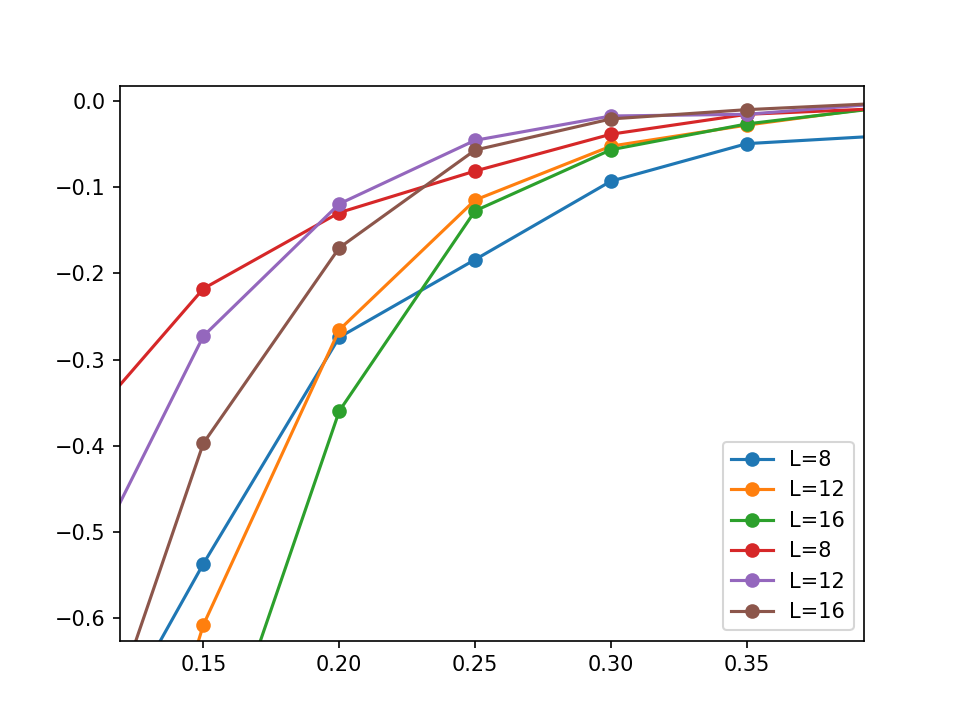

12
16
8
12
16


In [4]:
p_list = np.round(np.arange(0.05,0.5,0.05),2)
MI_dic = MI_vs_L_2
for L in MI_dic:
  
    MI = np.array(MI_dic[L])
    MI_avg = []
    for i in range(MI.shape[0]):
        MI_p = MI[i,:]
        nan_indices = np.argwhere(np.isnan(MI_p))
        MI_p = np.delete(MI_p,nan_indices)
        MI_avg.append(np.average(MI_p))
    print(L)
    pl.plot(p_list,MI_avg,'-o',label='L='+str(L))
pl.legend()

MI_dic = MI_vs_L
for L in MI_dic:
  
    MI = np.array(MI_dic[L])
    MI_avg = []
    for i in range(MI.shape[0]):
        MI_p = MI[i,:]
        nan_indices = np.argwhere(np.isnan(MI_p))
        MI_p = np.delete(MI_p,nan_indices)
        MI_avg.append(np.average(MI_p))
    print(L)
    pl.plot(p_list,MI_avg,'-o',label='L='+str(L))
pl.legend()

In [ ]:
with open("MI_data_dense_using_local_function",'wb') as f:
    pickle.dump(MI_vs_L,f)

In [3]:
with open("MI_data_random_using_local_function",'rb') as f:
    MI_vs_L_2 = pickle.load(f)

In [ ]:
for L in MI_vs_L_2:
  
    MI = np.array(MI_vs_L_2[L])
    MI_avg = []
    for i in range(MI.shape[0]):
        MI_p = MI[i,:]
        nan_indices = np.argwhere(np.isnan(MI_p))
        MI_p = np.delete(MI_p,nan_indices)
        MI_avg.append(np.average(MI_p))
    print(L)
    pl.plot(p_list,MI_avg,'-o',label='L='+str(L))
pl.legend()

for L in MI_vs_L:
  
    MI = np.array(MI_vs_L[L])
    MI_avg = []
    for i in range(MI.shape[0]):
        MI_p = MI[i,:]
        nan_indices = np.argwhere(np.isnan(MI_p))
        MI_p = np.delete(MI_p,nan_indices)
        MI_avg.append(np.average(MI_p))
    print(L)
    pl.plot(p_list,MI_avg,'-o',label='L='+str(L))
pl.legend()

In [ ]:
ent_vs_L = {}
p_list = np.round(np.arange(0.05,0.5,0.05),2)

for L in [8,10,12,14,16]:
    T = 3*L
    print(len(np.arange(int(L/2)-1,L,1)),L/2-1)
    ent_avg = load_data(L,T)
    ent_vs_L[L] = ent_avg
    pl.plot(p_list,np.average(np.array(ent_avg)[:]/((L/2)),axis=-1),'-o',label=r'$L=$'+str(L))
pl.legend()

In [ ]:
for L in ent_vs_L:
    print(len(np.arange(int(L/2),L,1)),L/2)
    pl.plot(p_list,np.average(np.array(ent_vs_L[L])[:] / L,axis=-1),'-o',label='L='+str(L))
pl.legend()

In [ ]:
outcome_str = list(results.get_counts().keys())[0]
outcome_str = list(reversed(outcome_str))
outcome_list = []
for s in outcome_str[2:]:
    if not outcome_list:
        outcome_list.append([])
    if s != ' ':
        outcome_list[-1].append(int(s))
    else:
        outcome_list.append([])
print(outcome_str,'\n',outcome_list)
print(p_locations, results.get_counts(circ))

In [ ]:
pl.plot(entropy_list)
entropy_list

In [ ]:
circ.draw('mpl')
circ.size()

In [ ]:
circ.save_state('1')
U = qiskit.extensions.UnitaryGate(heisenberg(1),label='XXX')
circ.append(U,[q[0],q[1]])

In [ ]:
circ.draw()

In [ ]:
backend = Aer.get_backend('statevector_simulator')
config = backend.configuration()
# print(config.multi_meas_enabled)
job = qiskit.execute(circ,backend=backend)
results = job.result()
state = results.get_statevector(circ)
state = np.asarray(state).reshape((2,)*4)


In [ ]:
results.data()

In [ ]:
np.where(state!=0)

In [ ]:
(state.T)[:,:,0,1]

In [ ]:
(U@np.array([0,0,1,0])).reshape((2,2))

In [ ]:
heisenberg(1)

In [ ]:
0.84147098**2

In [ ]:
circ.size()

In [ ]:
circ.num_qubits

In [ ]:
circ.draw()